In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

%matplotlib inline

# Simulation

In [7]:
# Params
n = 1000
f_true = lambda X: 2*X[:,0] + X[:,1] #np.square((X[:,0] + X[:,1]))*2/12.901058

# Generate Data
X = np.matrix(np.random.randn(2*n, 2))

# Remove outliers
ind_not_outlier = np.array(np.multiply((abs(X) < 3)[:,0], (abs(X) < 3)[:,1]).T)[0]
X = X[ind_not_outlier, :][0:n, :]

# square elements of X
X = np.power(X, 2)
Y = f_true(X) + np.random.randn(n, 1)/1000

In [8]:
def trim(X, percent):
    
    alpha = (1 - percent)/2
    n, k = np.shape(X)
    t_ind = np.zeros((n, k))
    
    for i in range(0, k):
        upper_bd = np.percentile(X[:,i], (1 - alpha)*100)
        lower_bd = np.percentile(X[:,i], (alpha)*100)
        t_ind[:, i] = [int(lower_bd < x < upper_bd) for x in X[:,i]]
        
    return np.prod(t_ind, axis = 1)

# Conditional Expecttation
def CE_1(Y, X, arg, r):
    
    n_arg = np.shape(arg)[0]
    n = np.shape(X)[0]
    h = (n**(-r)) * np.std(X, axis = 0, ddof = 1)
    e = np.zeros((n_arg, 1))
    
    for j in range(0, n_arg):
        k = np.divide(norm.pdf(np.divide((arg[j] - X), h)), h)
        k = np.prod(k, axis = 1)   
        e[j] = (Y.T*k/n)/np.mean(k)
        
    return e

def SLS_1(b, Y, X, X_ind):
    
    v = X * np.matrix(b).T
    EY = CE_1(Y, v, v, 1/5)
    residual = np.power((Y - EY), 2)
    
    return (-0.5 * np.matrix(X_ind)*residual)


def semiparametricRegression(Y, X):
    
    guess = np.random.random((1, np.shape(X)[1]))
    obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
    result = minimize(obj_f, guess, method='BFGS')
    return result

def convert_hessian_to_cov(Y, X, results):
    
    sigma_2_hat = np.mean(np.power(Y - X*np.matrix(results.x).T, 2))
    return results.hess_inv * sigma_2_hat

def compute_marginal_effect(Y, X, ind, point, beta, delta = 0.01):

    point_nudge = np.copy(point)
    point_nudge[0, ind] = point_nudge[0, ind] + delta
    point_nudge = np.matrix(point_nudge)

    v_hat = X*beta
    v_hat_avg = point*beta
    v_hat_avg_nudge = point_nudge*beta
    
    return np.asscalar(CE_1(Y, v_hat, v_hat_avg_nudge, 1/5) - CE_1(Y, v_hat, v_hat_avg, 1/5))/delta

def calculate_me_range(Y, X, result, ind, point, delta = .001, delta_range = [0.0001, 0.01], parameter_range = [0, 0.014], n_1 = 200, n_2 = 5):

    beta = np.matrix(result.x).T
    
    me_results = np.zeros(shape = (n_1, 2, n_2))
    
    linspace_1 = np.linspace(parameter_range[0], parameter_range[1], num = n_1)
    linspace_2 = np.linspace(delta_range[0], delta_range[1], num = n_2)
    
    for j in range(0, n_2):

        delta = linspace_2[j]
        #primp_avgt = np.linspace(0.001, 0.5, num = n_2)[j]

        for i in range(0, n_1):
  
            point_temp = np.copy(point)
            point_temp[0, ind] = linspace_1[i]
            
            me_vec = compute_marginal_effect(Y, X, ind, point_temp, beta, delta = delta)

            me_results[i,:,j] = np.array([linspace_1[i], np.asscalar(me_vec)])
            
    return me_results   

def find_tstats(Y, X, results):
    
    V = convert_hessian_to_cov(Y, X, results)

    n = np.shape(results.x)[0]
    theta = results.x/results.x[0]
    t_stats = np.zeros(shape = (n))
    t_stats[0] = np.nan # first t-stat is unknown

    for i in range(1, n):
        t_stats[i] = theta[i] / np.sqrt(V[i,i])

    return t_stats

In [9]:
# scratch 
v = X*np.matrix(result.x).T
#Y*np.log(v.T) + (1-Y)*np.log(1 - v.T)
np.array([1.99956511, 1.00577001]) - np.array([1.99956511, 1.00577001])

NameError: name 'result' is not defined

In [ ]:
# simulation
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, [2,1], method='SLSQP', options={'ftol': 10**-4})
result

In [ ]:
# Scratch 

print('Coefficient ratio: %0.3f' % (result.x[0] / result.x[1]))


In [ ]:
# Marginal effect scratch
delta = 1.5

beta = np.matrix(result.x).T
X_new = np.copy(X)
X_new[:,0] = np.reshape(X[:,0] + delta, (np.shape(X)[0]))

v_hat = X*beta
v_hat_new = X_new*beta

me_vec = CE_1(Y, v_hat, v_hat_new, 1/5) - CE_1(Y, v_hat, v_hat, 1/5)
plt.hist(me_vec)
print('Avg ME: %0.5f' % np.mean(me_vec/delta))
true_vec = f_true(X_new) - f_true(X)
print('True ME: %0.5f' % np.mean(true_vec/delta))

In [ ]:
me_results = []

for delta in np.linspace(0.01, 10, num = 10):
    
    beta = np.matrix(result.x).T
    X_new = np.copy(X)
    X_new[:,0] = np.reshape(X[:,0] + delta, (np.shape(X)[0]))

    v_hat = X*beta
    v_hat_new = X_new*beta

    me_vec = CE_1(Y, v_hat, v_hat_new, 1/5) - CE_1(Y, v_hat, v_hat, 1/5)
    me_results.append([delta, np.mean(me_vec/delta)])
    
me_results   

## Parametric Tobit

In [37]:
# Tobit Objective
def Tobit(b, Y, X, X_ind):
    
    beta = b[0:-1]
    sig  = b[-1]
    sig2 = sig**2
    v = X * np.matrix(beta).T
    t =  Y > 0
    P = norm.cdf(v);
    L0 = np.log(1-np.clip(P, 0.00001, 0.99999))  ;                            # likehood for the zeros
    LP = -.5*np.log(sig2) - .5*np.power(((Y/sig) - v), 2);   # likelihood for Positive Y's
    LogL = np.multiply((1-t), L0) + np.multiply((t), LP);            # Overall likelihood
    return np.sum(LogL)

In [45]:



obj_f = lambda x_0: -Tobit(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, [2,1,0.02], method='BFGS')
result

      fun: -5828.581816655579
 hess_inv: array([[ 2.64911463e+00,  1.32423119e+00, -1.01458295e-05],
       [ 1.32423119e+00,  6.62476445e-01, -5.07272615e-06],
       [-1.01458295e-05, -5.07272615e-06,  3.88683631e-11]])
      jac: array([-1.08375916e+02, -7.78497925e+01, -3.65023009e+07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 3511
      nit: 472
     njev: 700
   status: 2
  success: False
        x: array([7.26728628e+02, 3.63350809e+02, 2.75194305e-03])

AttributeError: hessinv

# Actual Data

In [2]:
import pandas as pd

In [3]:
n = 1400 # sample size
data_dmd = pd.read_csv('../data/processed/regression_data_levels.csv').query('OrderType == "Market"').drop('Rebate', axis = 1).dropna()#.sample(n = n)
display(data_dmd.shape)
display(data_dmd.query('MktShare == 0').shape)

(2292, 49)

(964, 49)

In [4]:
data_dmd.head()

,MarketCenter,Quarter,Exchange,OrderCode,CoveredOrders,CoveredShares,CancelledShares,MktCtrExecShares,AwayExecShares,ExecShares_0_9,...,MktCtrAvg_PrImp_AvgT,Rel_PrImp_AvgT,MktCtrAvg_PrImp_ExpAmt,Rel_PrImp_ExpAmt,MktCtrAvg_All_AvgT,Rel_All_AvgT,Broker,MktShare,Rebate_Dummy,Broker_Size
4,AQUA,2016Q2,NASDAQ,11,92,465340,158940,303400,0,296000,...,0.146865,0.313173,0.010230,0.019600,0.200564,0.300425,Credit Suisse,0.0,1,3.266721e+10
5,AQUA,2016Q2,NASDAQ,11,92,465340,158940,303400,0,296000,...,0.146865,0.313173,0.010230,0.019600,0.200564,0.300425,Deutsche,0.0,1,2.045009e+10
8,AQUA,2016Q2,NYSE,11,99,499672,186672,303200,9800,313000,...,0.124222,-0.022209,0.006555,0.010075,0.249455,-0.157250,Cowen Execution,0.0,0,5.018710e+07
9,AQUA,2016Q2,NYSE,11,99,499672,186672,303200,9800,313000,...,0.124222,-0.022209,0.006555,0.010075,0.249455,-0.157250,Credit Suisse,0.0,1,3.266721e+10
10,AQUA,2016Q2,NYSE,11,99,499672,186672,303200,9800,313000,...,0.124222,-0.022209,0.006555,0.010075,0.249455,-0.157250,Deutsche,0.0,1,2.045009e+10


### All

In [5]:
data_dmd_mat = np.matrix(data_dmd[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_mat[:,0]
X = data_dmd_mat[:,1:]
guess = [1.00853382, -0.00344227]

NameError: name 'np' is not defined

In [124]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, guess, method='BFGS', options = {'gtol': 1e-03, 'maxiter': 4})
tstats_all = find_tstats(Y, X, result)
result_all = result
result

      fun: 41.85115170808477
 hess_inv: array([[ 9.98473892e-01, -3.40368792e-03],
       [-3.40368792e-03,  3.81150003e-05]])
      jac: array([0.0001421 , 0.04894066])
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 40
      nit: 4
     njev: 10
   status: 1
  success: False
        x: array([ 1.00686087, -0.00293335])

### Rebate accepting

In [125]:
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 1')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

In [126]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, guess, method='BFGS')
tstats_paid = find_tstats(Y, X, result)
result_paid = result
result

      fun: 1.7024893207071667
 hess_inv: array([[ 1.00256441, -0.00150625],
       [-0.00150625,  0.00243805]])
      jac: array([-4.47034836e-08,  1.49011612e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 6
     njev: 15
   status: 0
  success: True
        x: array([ 0.99905107, -0.01578509])

### Unpaid

In [127]:
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 0')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

In [128]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, guess, method='BFGS', options = {'gtol': 1e-03, 'maxiter': 4})
tstats_unpaid = find_tstats(Y, X, result)
result_unpaid = result
result

      fun: 35.569807662681036
 hess_inv: array([[ 1.11692680e+00, -6.18200799e-03],
       [-6.18200799e-03,  1.04652960e-04]])
      jac: array([-7.34329224e-05, -3.93290520e-02])
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 40
      nit: 4
     njev: 10
   status: 1
  success: False
        x: array([ 1.00077912, -0.00185409])

## Significance

In [45]:
display('T-Stats (All)', tstats_all)
display('T-Stats (Paid)', tstats_paid)
display('T-Stats (Unpaid)', tstats_unpaid)

'T-Stats (All)'

array([      nan, -1.765061])

'T-Stats (Paid)'

array([        nan, -3.20505267])

'T-Stats (Unpaid)'

array([        nan, -0.59009845])

## Marginal Effects

matrix([[0.00624043, 0.09237883]])

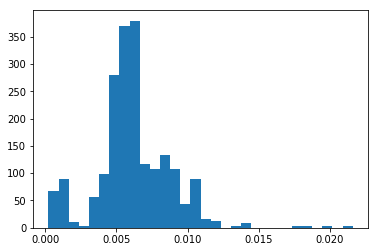

In [46]:
data_dmd_mat = np.matrix(data_dmd[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_mat[:,0]
X = data_dmd_mat[:,1:]
ind = 0
point = np.matrix(np.mean(X, axis = 0))

param_range = [0.0025, 0.01]
plt.hist(X[:,0], bins = 30);
point

### All

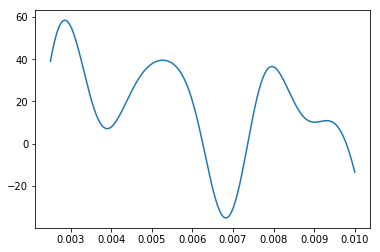

In [90]:
data_dmd_mat = np.matrix(data_dmd[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_mat[:,0]
X = data_dmd_mat[:,1:]

result = result_all
me_results = calculate_me_range(Y, X, result, ind, point, delta = .001, n_1 = 300, n_2 = 1, delta_range = [0.001, 0.01], parameter_range = param_range)
plt.plot(me_results[:,0],me_results[:,1]);

### Paid

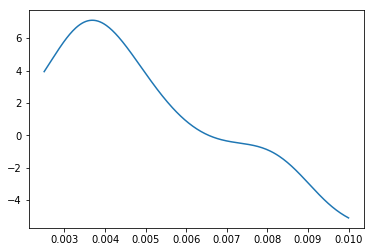

In [91]:
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 1')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

result = result_paid
me_results = calculate_me_range(Y, X, result, ind, point, delta = .001, n_1 = 300, n_2 = 1, delta_range = [0.001, 0.01], parameter_range = param_range)
plt.plot(me_results[:,0],me_results[:,1]);

### Unpaid

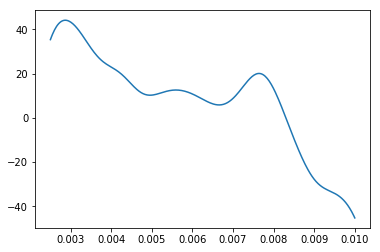

In [98]:
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 0')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

result = result_unpaid
me_results = calculate_me_range(Y, X, result, ind, point, delta = .001, n_1 = 300, n_2 = 1, delta_range = [0.003, 0.01], parameter_range = param_range)
plt.plot(me_results[:,0],me_results[:,1]);

In [109]:
point = np.mean(np.matrix(data_dmd[['PrImp_ExpAmt', 'PrImp_AvgT']]), axis = 0)
display(point)

data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 0')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y_unpaid = data_dmd_rebate_mat[:,0]
X_unpaid = data_dmd_rebate_mat[:,1:]
me_results_unpaid = calculate_me_range(Y, X, result_unpaid, ind, point, delta = .001, n_1 = 300, n_2 = 1, delta_range = [0.001, 0.0025], parameter_range = param_range)

data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy == 1')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y_paid = data_dmd_rebate_mat[:,0]
X_paid = data_dmd_rebate_mat[:,1:]
me_results_paid   = calculate_me_range(Y, X, result_paid,   ind, point, delta = .001, n_1 = 300, n_2 = 1, delta_range = [0.003, 0.0025], parameter_range = param_range)

matrix([[0.00624043, 0.09237883]])

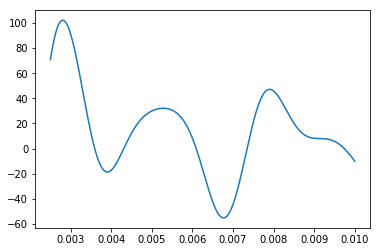

In [110]:
ind_3 = 0
# X parameter doesn't matter here, can be paid or unpaid, both ranges are the same (linspace_1 in function)
plt.plot(me_results_unpaid[:,0,:], me_results_unpaid[:,1,:] - me_results_paid[:,1,:])

### At Particular X's

In [75]:
# At CDRG's stats
CDRG_X = [0.01077, .161658]
delta = 0.001

display(compute_marginal_effect(Y, X, 0, np.matrix(CDRG_X), np.matrix(result_all.x).T,    delta = delta)*delta)
display(compute_marginal_effect(Y, X, 0, np.matrix(CDRG_X), np.matrix(result_paid.x).T,   delta = delta)*delta)
display(compute_marginal_effect(Y, X, 0, np.matrix(CDRG_X), np.matrix(result_unpaid.x).T, delta = delta)*delta)

-0.06412411177971386

0.011465387302266095

-0.0665041750171671

In [111]:
data_605 = pd.read_csv('../data/processed/605_processed.csv').dropna().query('OrderCode == 11')

PrImp_ExpAmt_mean = data_605['PrImp_ExpAmt'].mean()
PrImp_AvgT_mean = data_605['PrImp_AvgT'].mean()

display([PrImp_ExpAmt_mean, PrImp_AvgT_mean])

delta = 0.01

for x in range(0, 101, 25):

    print('\n\nPercentile: %d' % x)
    X_initial = [PrImp_ExpAmt_mean, PrImp_AvgT_mean]
    X_initial[0] = np.percentile(data_605['PrImp_ExpAmt'], x)

    print('ME: %0.5f' % (compute_marginal_effect(Y, X, 0, np.matrix(X_initial), np.matrix(result_all.x).T,    delta = delta)*delta))
    print('ME: %0.5f' % (compute_marginal_effect(Y_paid, X_paid, 0, np.matrix(X_initial), np.matrix(result_paid.x).T,   delta = delta)*delta))
    print('ME: %0.5f' % (compute_marginal_effect(Y_unpaid, X_unpaid, 0, np.matrix(X_initial), np.matrix(result_unpaid.x).T, delta = delta)*delta))
    print('Difference in ME: %0.8f' % ((compute_marginal_effect(Y_unpaid, X_unpaid, 0, np.matrix(X_initial), np.matrix(result_unpaid.x).T, delta = delta)*delta) - 
         (compute_marginal_effect(Y_paid, X_paid, 0, np.matrix(X_initial), np.matrix(result_paid.x).T,   delta = delta)*delta)))

[0.004360273984438516, 1.9866772850019099]



Percentile: 0
ME: -0.04973
ME: -0.16156
ME: 0.03282
Difference in ME: 0.19438103


Percentile: 25
ME: 0.03801
ME: -0.16173
ME: 0.05470
Difference in ME: 0.21643508


Percentile: 50
ME: 0.02250
ME: -0.16173
ME: 0.07636
Difference in ME: 0.23809738


Percentile: 75
ME: 0.08014
ME: -0.16173
ME: 0.04111
Difference in ME: 0.20284785


Percentile: 100
ME: -0.00000
ME: 0.03252
ME: -0.00000
Difference in ME: -0.03251697


In [116]:
delta = 0.01

for x in range(0, 101, 25):

    print('\n\nPercentile: %d' % x)
    X_initial = [PrImp_ExpAmt_mean, PrImp_AvgT_mean]
    X_initial[1] = np.percentile(data_605['PrImp_AvgT'], x)

    print('ME: %0.5f' % (compute_marginal_effect(Y, X, 0, np.matrix(X_initial), np.matrix(result_all.x).T,    delta = delta)*delta))
    print('ME: %0.5f' % (compute_marginal_effect(Y_paid, X_paid, 0, np.matrix(X_initial), np.matrix(result_paid.x).T,   delta = delta)*delta))
    print('ME: %0.5f' % (compute_marginal_effect(Y_unpaid, X_unpaid, 0, np.matrix(X_initial), np.matrix(result_unpaid.x).T, delta = delta)*delta))
    print('Difference in ME: %0.8f' % ((compute_marginal_effect(Y_unpaid, X_unpaid, 0, np.matrix(X_initial), np.matrix(result_unpaid.x).T, delta = delta)*delta) - 
         (compute_marginal_effect(Y_paid, X_paid, 0, np.matrix(X_initial), np.matrix(result_paid.x).T,   delta = delta)*delta)))



Percentile: 0
ME: -0.16617
ME: -0.05696
ME: -0.16099
Difference in ME: -0.10402914


Percentile: 25
ME: -0.16643
ME: -0.05479
ME: -0.16117
Difference in ME: -0.10637214


Percentile: 50
ME: -0.16839
ME: -0.04475
ME: -0.16224
Difference in ME: -0.11748790


Percentile: 75
ME: -0.11521
ME: 0.01419
ME: -0.15838
Difference in ME: -0.17256931


Percentile: 100
ME: nan
ME: nan
ME: nan
Difference in ME: nan


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


# Scratch

In [84]:
import scipy

data_dmd_rebate_mat = np.matrix(data_dmd.query('MktShare != -1')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

obj_f = lambda x_0: np.sum(np.power(Y - X*np.matrix(x_0).T, 2)) #-SLS_1(x_0, Y, X, trim(X, 0.98))[0,0]
result =  minimize(obj_f, [1,2], method='BFGS')
result

      fun: 96.64524801044234
 hess_inv: array([[ 7.01365158e+00, -1.05423757e-01],
       [-1.05423757e-01,  6.86709321e-03]])
      jac: array([-9.53674316e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([24.85331849, -0.09983802])

In [85]:
beta = np.linalg.inv(X.T*X)*X.T*Y
beta

matrix([[24.85332203],
        [-0.09983807]])

(array([  8.,   4.,  12.,  13.,  62., 110., 300., 271., 176., 216., 158.,
        114., 119.,  89.,  67.,  46.,  48.,  41.,  30.,  18.,  12.,  21.,
         15.,  14.,  12.,  10.,   6.,   3.,  13.,   2.]),
 array([-0.45120354, -0.4056834 , -0.36016325, -0.31464311, -0.26912297,
        -0.22360282, -0.17808268, -0.13256254, -0.08704239, -0.04152225,
         0.00399789,  0.04951804,  0.09503818,  0.14055833,  0.18607847,
         0.23159861,  0.27711876,  0.3226389 ,  0.36815904,  0.41367919,
         0.45919933,  0.50471947,  0.55023962,  0.59575976,  0.6412799 ,
         0.68680005,  0.73232019,  0.77784033,  0.82336048,  0.86888062,
         0.91440077]),
 <a list of 30 Patch objects>)

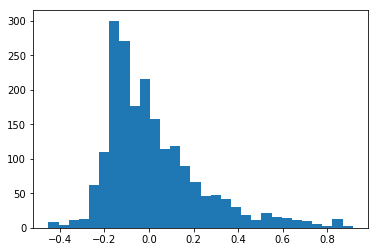

In [86]:
e_hat = Y - X*np.matrix(beta)

plt.hist(e_hat, bins = 30)

In [88]:
# mask = Y == 0
# e_hat[mask]

(array([  2.,   4.,   5.,  34., 113., 178., 214., 194., 166., 107.,  73.,
         62.,  37.,  23.,  25.,  25.,  20.,   8.,  11.,   7.]),
 array([-0.44820354, -0.38007332, -0.31194311, -0.24381289, -0.17568268,
        -0.10755246, -0.03942225,  0.02870797,  0.09683818,  0.1649684 ,
         0.23309861,  0.30122883,  0.36935904,  0.43748926,  0.50561947,
         0.57374969,  0.6418799 ,  0.71001012,  0.77814033,  0.84627055,
         0.91440077]),
 <a list of 20 Patch objects>)

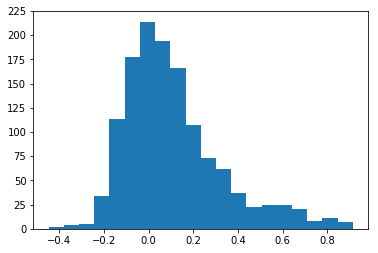

In [89]:
plt.hist(e_hat[Y != 0].T, bins = 20)

In [82]:
from scipy import stats
stats.normaltest(e_hat[Y != 0].T)

NormaltestResult(statistic=array([173.74078391]), pvalue=array([1.87356228e-38]))

In [83]:
e_hat[Y == 0]

matrix([], shape=(1, 0), dtype=float64)

In [154]:
data_dmd_rebate_mat = np.matrix(data_dmd.query('Rebate_Dummy != 0')[['MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']])
Y = data_dmd_rebate_mat[:,0]
X = data_dmd_rebate_mat[:,1:]

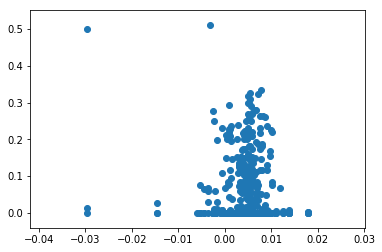

In [155]:
plt.scatter(np.array(X*np.matrix(result_paid.x).T).flatten(), np.array(Y).flatten())


In [60]:
beta = np.matrix([1, 2]).T

v = X * beta

In [56]:
Y.T*np.log(v) - (1-Y).T*(1-np.log(v))

matrix([[-6875.7337193]])

In [59]:
1-np.log(v)


matrix([[1.0513914 ],
        [1.0513914 ],
        [2.51115193],
        ...,
        [1.67624252],
        [1.67624252],
        [1.67624252]])

In [82]:
Y = np.power(X*beta, 2)
Y

matrix([[0.90232294],
        [0.90232294],
        [0.04868892],
        ...,
        [0.25859684],
        [0.25859684],
        [0.25859684]])

In [84]:
beta_hat = beta.copy()
beta_hat[0,0] = 1
print(beta)
print(beta_hat)

EY = 

np.matrix(CE_1(Y, X*beta_hat, X*beta_hat, 1/5))

Y.T*np.log(EY) - (1-Y).T*(1-np.log(EY))

[[1]
 [2]]
[[1]
 [2]]


matrix([[-10229.64299836]])

In [87]:
obj_f = lambda x_0: -SLS_1(x_0, Y, X, trim(X, 0.98))
result = minimize(obj_f, [1,2], method='BFGS', options = {'gtol': 1e-03, 'maxiter': 4})
result

      fun: 0.12448397153288487
 hess_inv: array([[ 454.9324879 , -227.80408302],
       [-227.80408302,  115.32095205]])
      jac: array([-0.00017157,  0.00021936])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 2
     njev: 6
   status: 0
  success: True
        x: array([1.94858844, 1.52429289])